# Нейронные сети
__Суммарное количество баллов: 10__

__Решение отправлять на `ml.course.practice@gmail.com`__

__Тема письма: `[ML][HW06] <ФИ>`, где вместо `<ФИ>` указаны фамилия и имя__

Для начала вам предстоит реализовать свой собственный backpropagation и протестировать его на реальных данных, а затем научиться обучать нейронные сети при помощи библиотеки `PyTorch` и использовать это умение для классификации классического набора данных CIFAR10.

In [215]:
import numpy as np
import copy
from sklearn.datasets import make_blobs, make_moons
import scipy.special
import typing
import math

### Задание 1 (3 балла)
Нейронные сети состоят из слоев, поэтому для начала понадобится реализовать их. Пока нам понадобятся только три:

`Linear` - полносвязный слой, в котором `y = Wx + b`, где `y` - выход, `x` - вход, `W` - матрица весов, а `b` - смещение. 

`ReLU` - слой, соответствующий функции активации `y = max(0, x)`.

`Softmax` - слой, соответствующий функции активации [softmax](https://ru.wikipedia.org/wiki/Softmax)


#### Методы
`forward(X)` - возвращает предсказание для `X`. `X` может быть как вектором, так и батчем

`backward(d)` - считает градиент при помощи обратного распространения ошибки. Возвращает новое значение `d`

`update(alpha)` - обновляет веса (если необходимо) с заданой скоростью обучения

In [216]:
class Module:
    def forward(self, x):
        raise NotImplementedError()

    def backward(self, d):
        raise NotImplementedError()

    def update(self, alpha):
        pass


class Linear(Module):
    def __init__(self, in_features, out_features):
        self.W = np.random.uniform(-1, 1, size=(out_features, in_features + 1))
        self.x = None
        self.d = None

    def forward(self, X):
        self.x = copy.deepcopy(X)
        self.x = self.x if len(self.x.shape) > 1 else self.x.reshape(-1, 1)
        self.x = np.vstack((self.x, np.ones((1, self.x.shape[1]))))
        return self.W.dot(self.x)

    def backward(self, d):
        self.d = copy.deepcopy(d)
        return (self.d.T.dot(self.W).T)[:-1]

    def update(self, alpha):
        self.W -= alpha * (self.d.dot(self.x.T))


class ReLU(Module):
    def __init__(self):
        self.x = None
        self.y = None

    def forward(self, x):
        self.x = copy.deepcopy(x)
        self.x = self.x if len(self.x.shape) > 1 else self.x.reshape(-1, 1)
        self.y = np.maximum(self.x, 0)
        return copy.deepcopy(self.y)

    def backward(self, d):
        pd = copy.deepcopy(self.x)
        pd[pd >= 0] = 1
        pd[pd < 0] = 0
        return pd * d

class Softmax(Module):
    def __init__(self):
        self.x = None
        self.y = None

    def forward(self, x):
        # print(self.x)
        self.x = copy.deepcopy(x)
        self.x = self.x if len(self.x.shape) > 1 else self.x.reshape(-1, 1)
        self.y = scipy.special.softmax(x, axis=0)
        return copy.deepcopy(self.y)

    def backward(self, d):
        pd = [
            [
                sum(
                    (self.y[i][j] * (1 - self.y[i][j]) if i == k else 
                     -self.y[k][j] * self.y[i][j]) * d[k][j]
                    for k in range(d.shape[0])
                   )
                for j in range(d.shape[1])
            ]
            for i in range(d.shape[0])
        ]
        pd = np.array(pd)
        return pd

### Задание 2 (2 балла)
Теперь сделаем саму нейронную сеть.

#### Методы
`fit(X, y)` - обучает нейронную сеть заданное число эпох. В каждой эпохе необходимо использовать [cross-entropy loss](https://ml-cheatsheet.readthedocs.io/en/latest/loss_functions.html#cross-entropy) для обучения, а так же производить обновления не по одному элементу, а используя батчи.

`predict_proba(X)` - предсказывает вероятности классов для элементов `X`

#### Параметры конструктора
`modules` - список, состоящий из ранее реализованных модулей и описывающий слои нейронной сети. В конец необходимо добавить `Softmax`

`epochs` - количество эпох обучения

`alpha` - скорость обучения

In [221]:
class MLPClassifier:

    def __init__(self, modules: typing.List[Module], epochs=40, alpha=0.01):
        self.modules = modules + [Softmax()]
        self.epochs = epochs
        self.alpha = alpha

    def forward(self, curx):
        for layer in self.modules:
            curx = layer.forward(curx)
        return curx
        
    def backward(self, curd):
        for layer in reversed(self.modules):
            curd = layer.backward(curd)
            layer.update(self.alpha)
        return curd
        
    def epoch(self):
        curx = self.forward(copy.deepcopy(self.X))
        curd = [
            [
                (0 if self.y[j] != i else -1.0 / curx[i][j])
                for j in range(curx.shape[1])
            ]
            for i in range(curx.shape[0])
        ]
        loss = 0
        for j in range(curx.shape[1]):
            label = self.y[j]
            xj = curx[label][j]
            # print(xj)
            loss -= math.log(xj)
        # print(f'loss = {loss}')
        curd = np.array(curd)
        self.backward(curd)

    def fit(self, X, y):
        self.X = copy.deepcopy(X)
        if len(self.X.shape) == 1:
            self.X = self.X.reshape(-1, 1)
        self.X = self.X.T
        self.y = copy.deepcopy(np.array(y)).reshape(-1)
        for _ in range(self.epochs):
            self.epoch()

    def predict_proba(self, X):
        return self.forward(copy.deepcopy(X).T).T

    def predict(self, X):
        p = self.predict_proba(X)
        return np.argmax(p, axis=1)

In [218]:
p = MLPClassifier([
    Linear(4, 64),
    ReLU(),
    Linear(64, 64),
    ReLU(),
    Linear(64, 2)
])

X = np.random.randn(50, 4)
y = [(0 if x[0] > x[2]**2 or x[3]**3 > 0.5 else 1) for x in X]
p.fit(X, y)

loss = 360.70895796238244
loss = 3124.0479891920645
loss = 483.33756580490234
loss = 567.4627928003304
loss = 76.65944016650518
loss = 6.4480790491131765
loss = 0.9503839973629694
loss = 0.7794745911388128
loss = 0.6670310579818122
loss = 0.58473133996945
loss = 0.521365830865108
loss = 0.4705655954439875
loss = 0.42924841014167947
loss = 0.3950564291474643
loss = 0.3688728702876028
loss = 0.342391488402279
loss = 0.3230095568824471
loss = 0.30311888795410197
loss = 0.2880016657352036
loss = 0.27224551471787534
loss = 0.2603428073530437
loss = 0.24754952928095939
loss = 0.23787652339926185
loss = 0.2267555717425855
loss = 0.21886918139006767
loss = 0.2095481981245704
loss = 0.20282706584553675
loss = 0.19462978782847737
loss = 0.18844879007645524
loss = 0.18153559161579497
loss = 0.17603815382771165
loss = 0.17010096176594303
loss = 0.1651704855650618
loss = 0.15996719983398217
loss = 0.155569387570411
loss = 0.1509602813399851
loss = 0.14701951989380949
loss = 0.14293110537238407
loss

### Задание 3 (2 балла)
Протестируем наше решение на синтетических данных. Необходимо подобрать гиперпараметры, при которых качество полученных классификаторов будет достаточным.

#### Оценка
Accuracy на первом датасете больше 0.85 - +1 балл

Accuracy на втором датасете больше 0.85 - +1 балл

In [229]:
X, y = make_moons(400, noise=0.075)
X_test, y_test = make_moons(400, noise=0.075)
print(X.shape, X_test.shape)
print(y_test.shape)

(400, 2) (400, 2)
(400,)


In [232]:
best_acc = 0
for _ in range(25):
    p = MLPClassifier(
        [
            Linear(2, 64),
            ReLU(),
            Linear(64, 64),
            ReLU(),
            Linear(64, 2)
        ],
        alpha = 1e-3
    )

    p.fit(X, y)
    best_acc = max(np.mean(p.predict(X_test) == y_test), best_acc)
print("Accuracy", best_acc)

Accuracy 1.0


In [227]:
X, y = make_blobs(400, 2, centers=[[0, 0], [2.5, 2.5], [-2.5, 3]])
X_test, y_test = make_blobs(400, 2, centers=[[0, 0], [2.5, 2.5], [-2.5, 3]])
best_acc = 0
for _ in range(25):
    p = MLPClassifier(
        [
            Linear(2, 64),
            ReLU(),
            Linear(64, 64),
            ReLU(),
            Linear(64, 3)
        ],
        alpha = 1e-4
    )

    p.fit(X, y)
    best_acc = max(np.mean(p.predict(X_test) == y_test), best_acc)
print("Accuracy", best_acc)

Accuracy 0.955


## PyTorch

Для выполнения следующего задания понадобится PyTorch. [Инструкция по установке](https://pytorch.org/get-started/locally/)

Если у вас нет GPU, то можно использовать [Google Colab](https://colab.research.google.com/)

In [120]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch
from tqdm import tqdm
from torch import nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [76]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

t = transforms.ToTensor()

cifar_train = datasets.CIFAR10("/datasets/cifar10", download=True, train=True, transform=t)
train_loader = DataLoader(cifar_train, batch_size=1024, shuffle=True, pin_memory=torch.cuda.is_available())
cifar_test = datasets.CIFAR10("/datasets/cifar10", download=True, train=False, transform=t)
test_loader = DataLoader(cifar_test, batch_size=1024, shuffle=False, pin_memory=torch.cuda.is_available())

Files already downloaded and verified
Files already downloaded and verified


### Задание 4 (3 балла)
А теперь поработам с настоящими нейронными сетями и настоящими данными. Необходимо реализовать сверточную нейронную сеть, которая будет классифицировать изображения из датасета CIFAR10. Имплементируйте класс `Model` и функцию `calculate_loss`. 

Обратите внимание, что `Model` должна считать в конце `softmax`, т.к. мы решаем задачу классификации. Соответствеено, функция `calculate_loss` считает cross-entropy.

Для успешного выполнения задания необходимо, чтобы `accuracy`, `mean precision` и `mean recall` были больше 0.5

__Можно пользоваться всем содержимым библиотеки PyTorch.__

In [98]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, x):
        pass
        
def calculate_loss(X, y, model):
    pass

Теперь обучим нашу модель. Для этого используем ранее созданные batch loader'ы.

In [77]:
def train(model, epochs=100):
    optimizer = torch.optim.Adam(model.parameters())
    train_losses = []
    test_losses = []
    for i in range(epochs):
        #Train
        loss_mean = 0
        elements = 0
        for X, y in iter(train_loader):
            X = X.to(device)
            y = y.to(device)
            loss = calculate_loss(X, y, model)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_mean += loss.item() * len(X)
            elements += len(X)
        train_losses.append(loss_mean / elements)
        #Test
        loss_mean = 0 
        elements = 0
        for X, y in iter(test_loader):
            X = X.to(device)
            y = y.to(device)
            loss = calculate_loss(X, y, model)
            loss_mean += loss.item() * len(X)
            elements += len(X)
        test_losses.append(loss_mean / elements)
        print("Epoch", i, "| Train loss", train_losses[-1], "| Test loss", test_losses[-1])
    return train_losses, test_losses

In [101]:
model = Model().to(device)
train_l, test_l = train(model)

Epoch 0 | Train loss 2.2292297332000732 | Test loss 2.149941352081299
Epoch 1 | Train loss 2.122715216369629 | Test loss 2.0939302814483645
Epoch 2 | Train loss 2.0884076861572267 | Test loss 2.078115378189087
Epoch 3 | Train loss 2.07821021194458 | Test loss 2.0765057807922362
Epoch 4 | Train loss 2.06793357093811 | Test loss 2.0650660312652587
Epoch 5 | Train loss 2.0629736500549316 | Test loss 2.0546842651367188
Epoch 6 | Train loss 2.0554406124114992 | Test loss 2.0537492122650147
Epoch 7 | Train loss 2.048790591430664 | Test loss 2.050680810546875
Epoch 8 | Train loss 2.0458059464263916 | Test loss 2.0568064170837403
Epoch 9 | Train loss 2.043578236618042 | Test loss 2.041243942260742
Epoch 10 | Train loss 2.036650228652954 | Test loss 2.0394827228546144
Epoch 11 | Train loss 2.0312407144927977 | Test loss 2.036195610809326
Epoch 12 | Train loss 2.0295346686553954 | Test loss 2.0343320095062256
Epoch 13 | Train loss 2.027185685195923 | Test loss 2.0283010162353516
Epoch 14 | Train

Построим график функции потерь

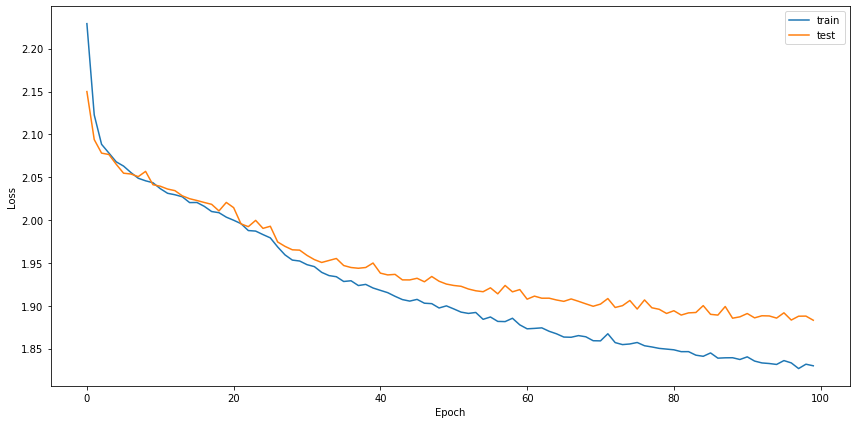

In [102]:
plt.figure(figsize=(12, 6))
plt.plot(range(len(train_l)), train_l, label="train")
plt.plot(range(len(test_l)), test_l, label="test")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.tight_layout()
plt.show()

И, наконец, посчитаем метрики

In [188]:
true_positive = np.zeros(10)
true_negative = np.zeros(10)
false_positive = np.zeros(10)
false_negative = np.zeros(10)
accuracy = 0
ctn = 0
for X, y in iter(test_loader):
    X = X.to(device)
    y = y.to(device)
    with torch.no_grad():
        y_pred = model(X).max(dim=1)[1]
    for i in range(10):
        for pred, real in zip(y_pred, y):
            if real == i:
                if pred == real:
                    true_positive[i] += 1
                else:
                    false_negative[i] += 1
            else:
                if pred == i:
                    false_positive[i] += 1
                else:
                    true_negative[i] += 1
            
    accuracy += torch.sum(y_pred == y).item()
    ctn += len(y)
print("Overall accuracy", accuracy / ctn)
print("Precision", true_positive / (true_positive + false_positive))
print("Recall", true_positive / (true_positive + false_negative))
print("Mean Precision", np.mean(true_positive / (true_positive + false_positive)))
print("Mean Recall", np.mean(true_positive / (true_positive + false_negative)))

Overall accuracy 0.5753
Precision [0.63374486 0.74829932 0.50492611 0.37551696 0.55428571 0.45979186
 0.60429722 0.6174812  0.68054211 0.61005199]
Recall [0.616 0.66  0.41  0.454 0.388 0.486 0.675 0.657 0.703 0.704]
Mean Precision 0.5788937349424892
Mean Recall 0.5753
